# BUI analyse d'un centre commercial
## Julien(Billeter, Muhlemann)

In [15]:
import numpy as np
import pandas as pd
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt

path = "data/"
filename = "marketing_campaign.csv"
def load_df(path=path, filename=filename):
    file_path = os.path.join(path, filename)
    data_df = pd.read_csv(file_path, sep='\t')
    return data_df



https://cedric.cnam.fr/vertigo/Cours/ml/tpDonneesManquantes.html

In [16]:
def clean_df(data_df):
    num_df = data_df.select_dtypes(include='number')
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=3)  # SimpleImputer(strategy='mean')
    imputed_num_df = pd.DataFrame(imputer.fit_transform(num_df), columns=num_df.columns)

    # Remove columns with std = 0
    imputed_num_df = imputed_num_df.loc[:, imputed_num_df.std() != 0]

    scaler = RobustScaler()
    non_num_df = data_df.select_dtypes(exclude='number')
    data_scaled = scaler.fit_transform(imputed_num_df)

    data_scaled_df = pd.DataFrame(data_scaled, columns=imputed_num_df.columns, index=imputed_num_df.index)
    final_df = pd.concat([data_scaled_df, non_num_df], axis=1)
    return final_df

data_df = load_df()
final_df = clean_df(data_df)

data_numerical = final_df.select_dtypes(include='number').copy()
data_non_numerical = final_df.select_dtypes(exclude='number').copy()

In [17]:
final_df.shape

(2240, 27)

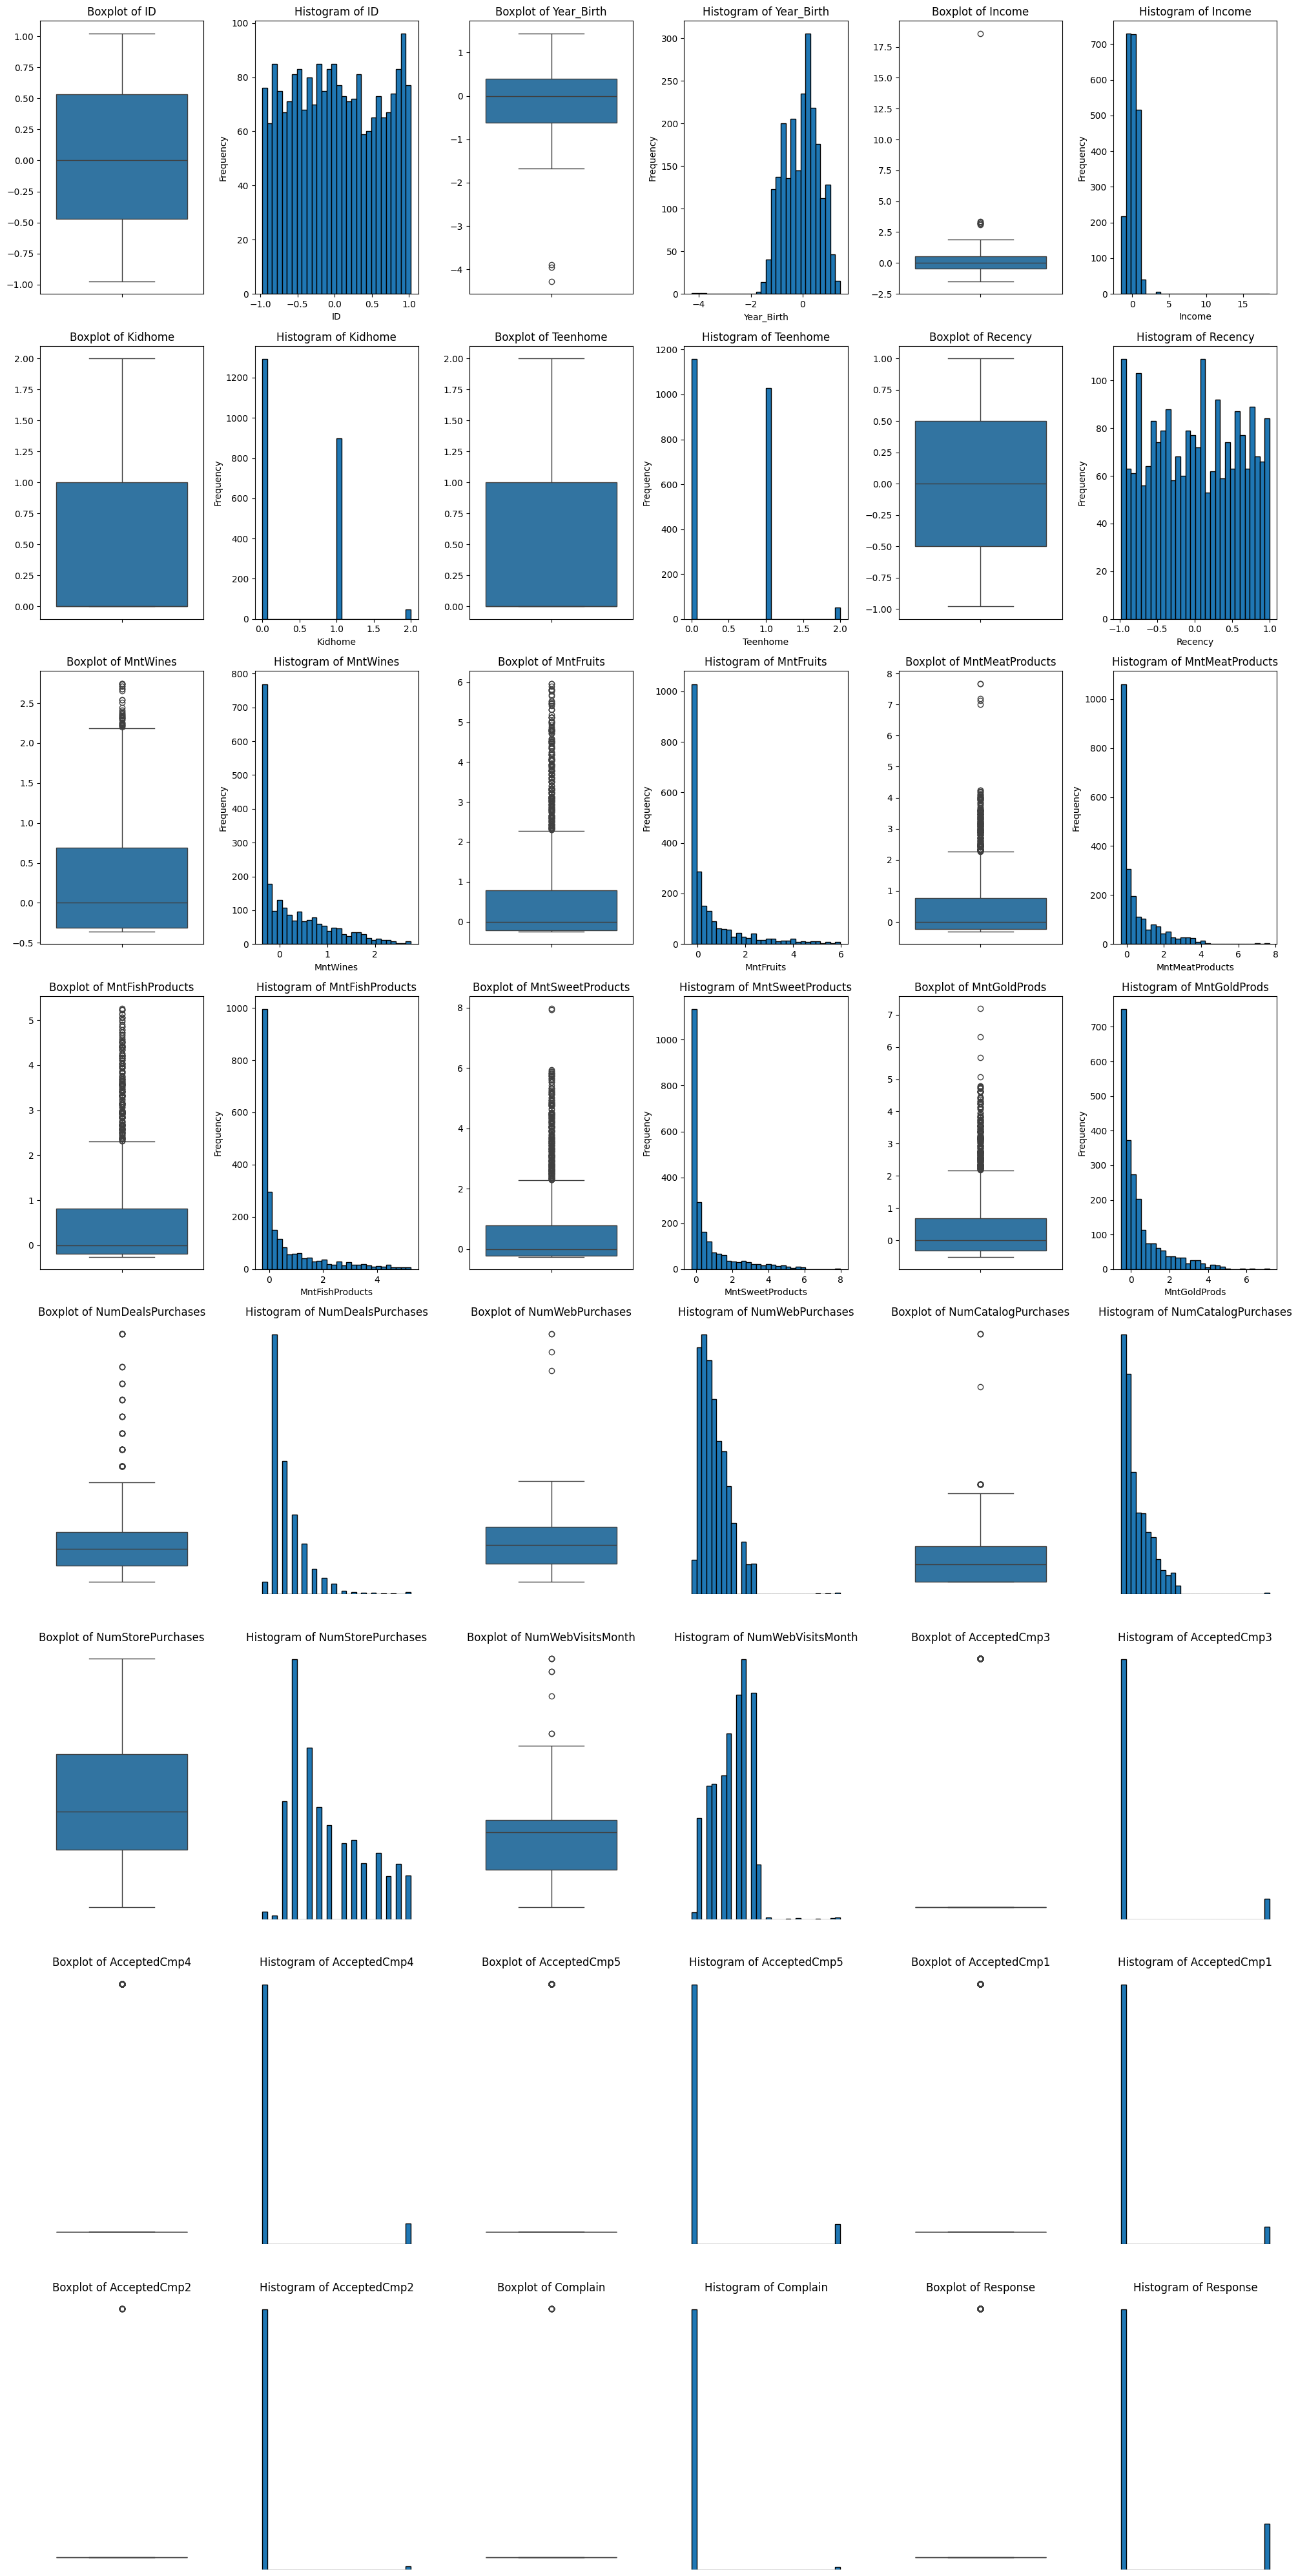

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_cols = 3  # Adjust the number of columns as needed
n_rows = (len(final_df.select_dtypes(include='number').columns) // n_cols) + (len(final_df.select_dtypes(include='number').columns) % n_cols > 0)  # Calculate rows needed

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(20, 5 * n_rows))  # Double the number of columns to accommodate both boxplot and histogram

# Flatten axes array for easy iteration if there are multiple rows
axes = axes.flatten()

# Loop through each column and create a boxplot and histogram
for i, col in enumerate(final_df.select_dtypes(include='number').columns):
    # Boxplot on the left
    sns.boxplot(ax=axes[2 * i], data=final_df[col])
    axes[2 * i].set_title(f'Boxplot of {col}')
    axes[2 * i].set_xlabel('')  # Optional: hide xlabel for clarity
    axes[2 * i].set_ylabel('')  # Optional: hide ylabel for clarity
    
    # Histogram on the right
    axes[2 * i + 1].hist(final_df[col], bins=30, edgecolor='black')
    axes[2 * i + 1].set_title(f'Histogram of {col}')
    axes[2 * i + 1].set_xlabel(col)
    axes[2 * i + 1].set_ylabel('Frequency')

# Hide any unused subplots (if the number of columns is not a perfect multiple of n_cols)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## K-means ++ PCA 2D

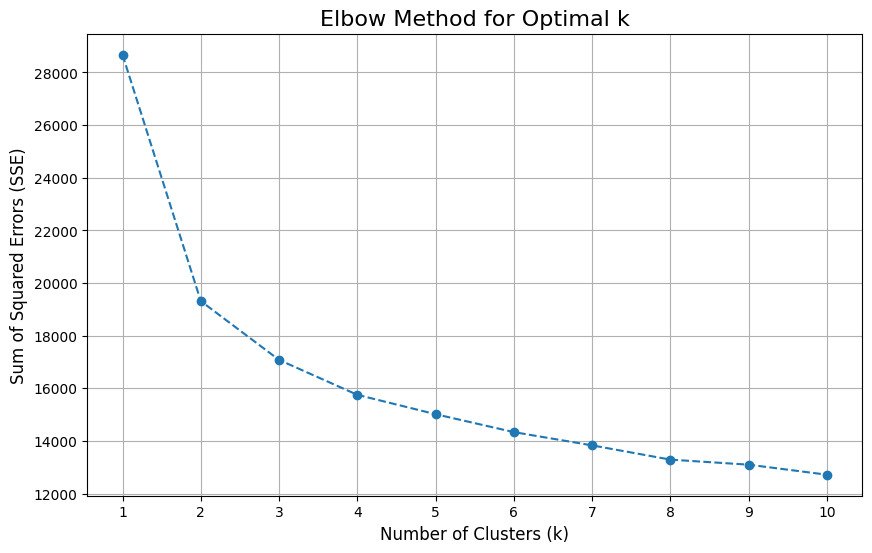

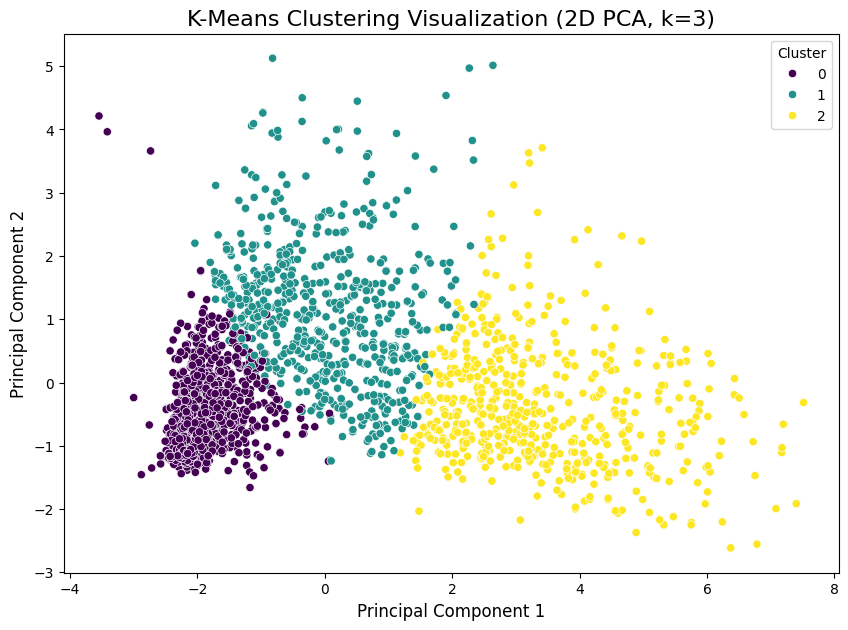

In [5]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Copy of the scaled data
data_scaled_df_k = data_numerical.copy()

# Step 1: Determine the optimal number of clusters using the elbow method
sse = []  # Sum of Squared Errors
k_range = range(1, 11)  # Test k values from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(data_scaled_df_k)
    sse.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Step 2: Apply K-Means++ with the optimal number of clusters
optimal_k = 3  # Replace with the elbow point identified from the plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++')
data_scaled_df_k['Cluster'] = kmeans.fit_predict(data_scaled_df_k)

# Add clusters to the final dataframe
final_df['Cluster'] = data_scaled_df_k['Cluster']

# Step 3: PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled_df_k.drop(columns='Cluster'))
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = data_scaled_df_k['Cluster']

# Step 4: Visualization of the Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=reduced_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title(f'K-Means Clustering Visualization (2D PCA, k={optimal_k})', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.show()


## K-means++ - PCA en 3D

In [22]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Select relevant features for segmentation
features = ['Income', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'Recency']
X = final_df[features].dropna()  # Drop rows with missing values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_scaled)  # Add clusters to the feature data only

# Perform PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for PCA results
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
X_pca_df['Cluster'] = X['Cluster']

# Plotly 3D Scatter Plot
fig = px.scatter_3d(
    X_pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='3D Visualization of K-Means Clustering (PCA)',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(scene=dict(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    zaxis_title='Principal Component 3'
))

# Show the interactive plot
fig.show()


## Pipeline [imputer + scaler + MLP] prédiction des comportements d'achat

c:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



Mean Squared Error (MSE): 0.7310
R² Score: 0.4331


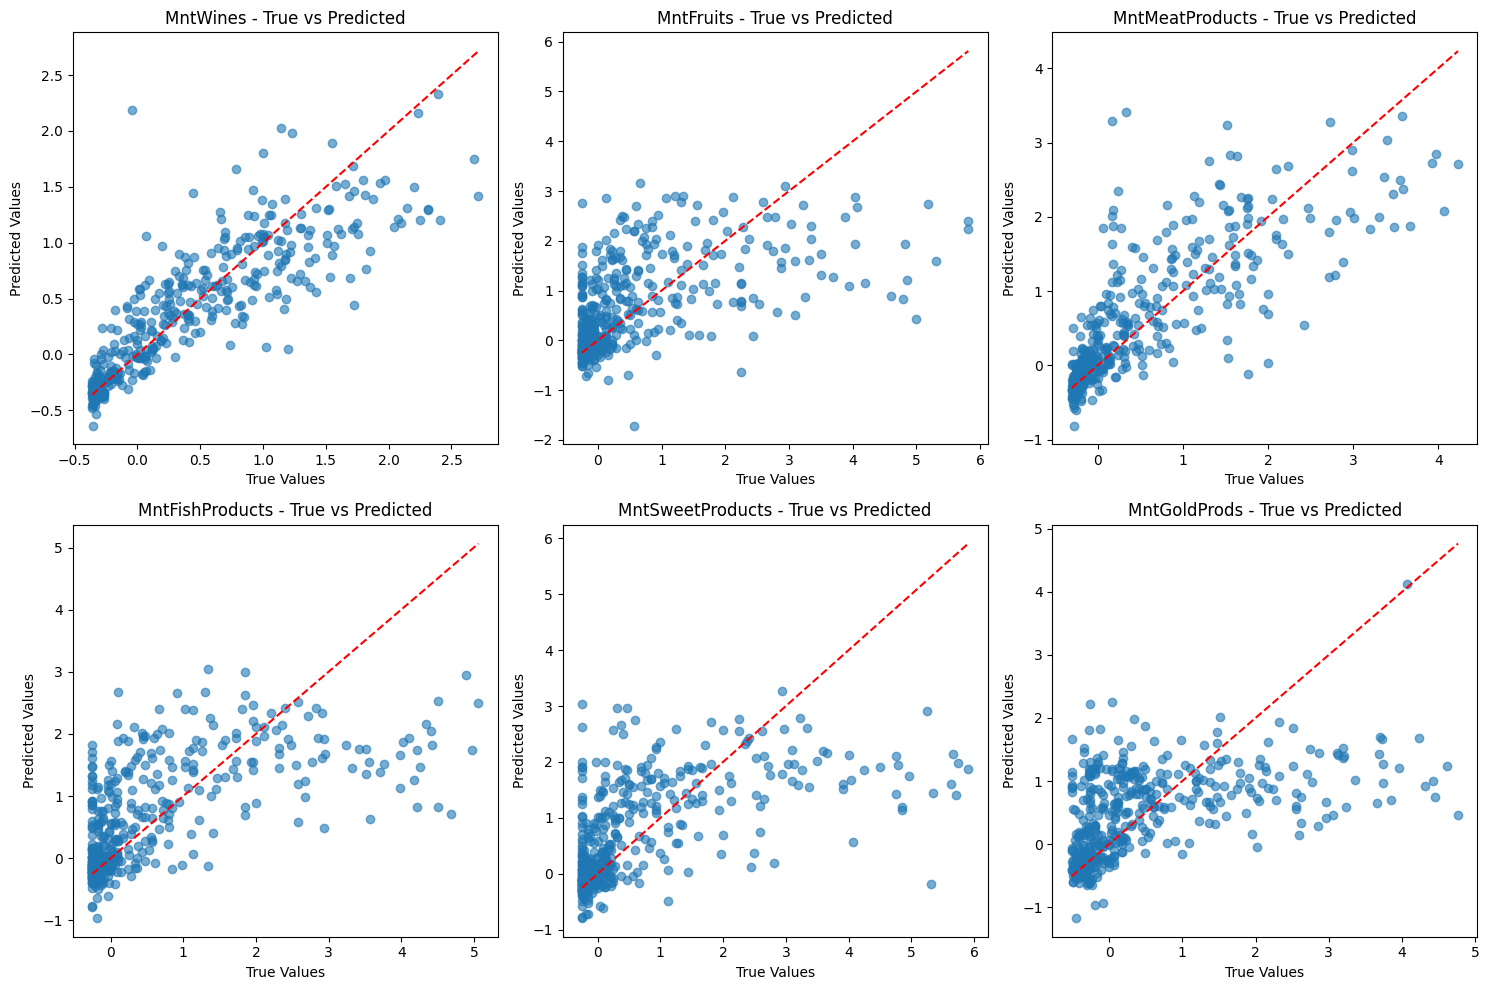

In [24]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Define the target columns
target_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Step 2: Preprocessing pipeline

# Define numeric columns (exclude the target variables and non-numeric columns)
numeric_cols = data_numerical.copy().select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in target_features]

# Define categorical columns
categorical_cols = data_numerical.select_dtypes(exclude='number').columns.tolist()

# Create a transformer for numeric columns (impute and scale)
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())  # Robust scaling
])

# Create a transformer for categorical columns (one-hot encode)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Combine both transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Step 3: Prepare the data

# Select features (X) and target (y)
X = data_numerical.drop(columns=target_features)  # Features
y = data_numerical[target_features]  # Target variables

# Step 4: Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Create a pipeline for the full process (Preprocessing + MLP)
mlp_pipeline = Pipeline(steps=[
    ('mlp', MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42))  # MLP Model
])

# Step 6: Train the MLP model
mlp_pipeline.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = mlp_pipeline.predict(X_test)

# Step 8: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# Step 9: Visualize predictions vs true values for each target feature
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, feature in enumerate(target_features):
    ax = axes[i // 3, i % 3]
    ax.scatter(y_test[feature], y_pred[:, i], alpha=0.6)
    ax.set_title(f'{feature} - True vs Predicted')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.plot([y_test[feature].min(), y_test[feature].max()],
            [y_test[feature].min(), y_test[feature].max()], color='red', linestyle='--')

plt.tight_layout()
plt.show()


## 

## Prédiction du revenus client avec random forest

MSE: 0.0647, R²: 0.8393


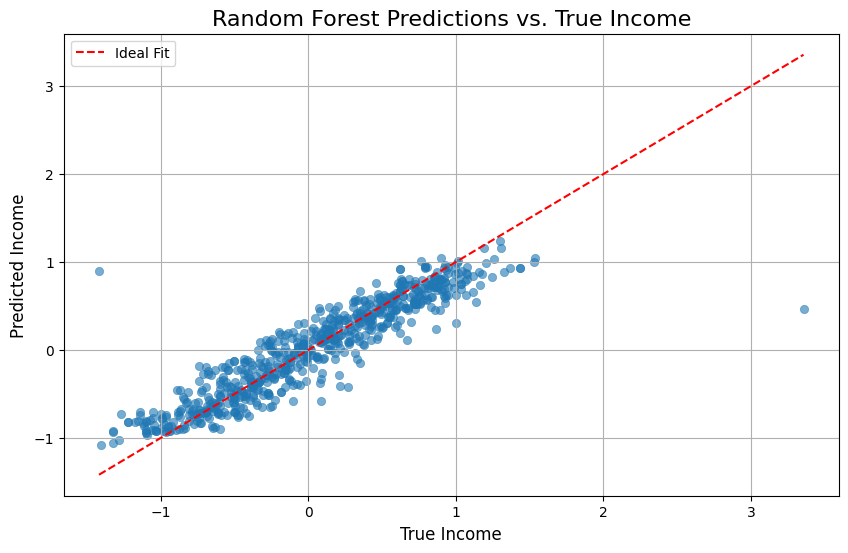

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define target (CLV proxy) and features
y = final_df['Income']  # Proxy for lifetime value
X = final_df.drop(columns=['Income', 'ID', 'Cluster'], errors='ignore')

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred):.4f}, R²: {r2_score(y_test, y_pred):.4f}')

# Plot true vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.title('Random Forest Predictions vs. True Income', fontsize=16)
plt.xlabel('True Income', fontsize=12)
plt.ylabel('Predicted Income', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


## Prédiction efficacité des campagnes marketing GradientBoosting

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       577
         1.0       0.60      0.27      0.38        95

    accuracy                           0.87       672
   macro avg       0.75      0.62      0.65       672
weighted avg       0.85      0.87      0.85       672



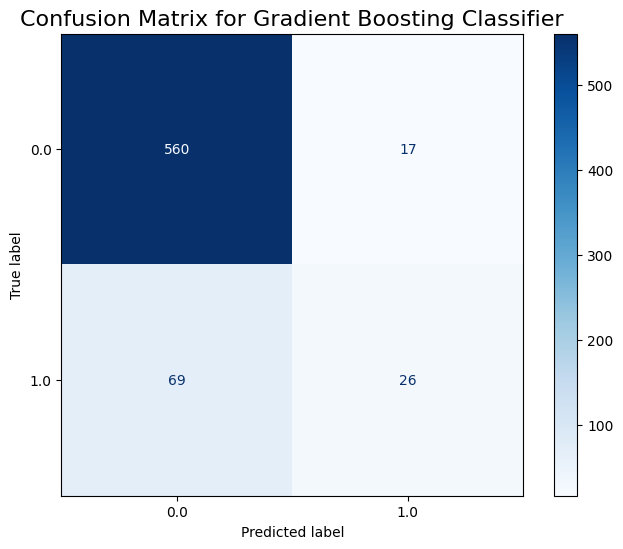

In [25]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Define target and features
y = final_df['Response']  # Response to campaigns
X = final_df.drop(columns=['Response', 'ID'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)

# Evaluate model
y_pred = gbc_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=gbc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc_model.classes_)

# Customize the plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix for Gradient Boosting Classifier", fontsize=16)
plt.show()


## analyse des préférences selon catégories de produit

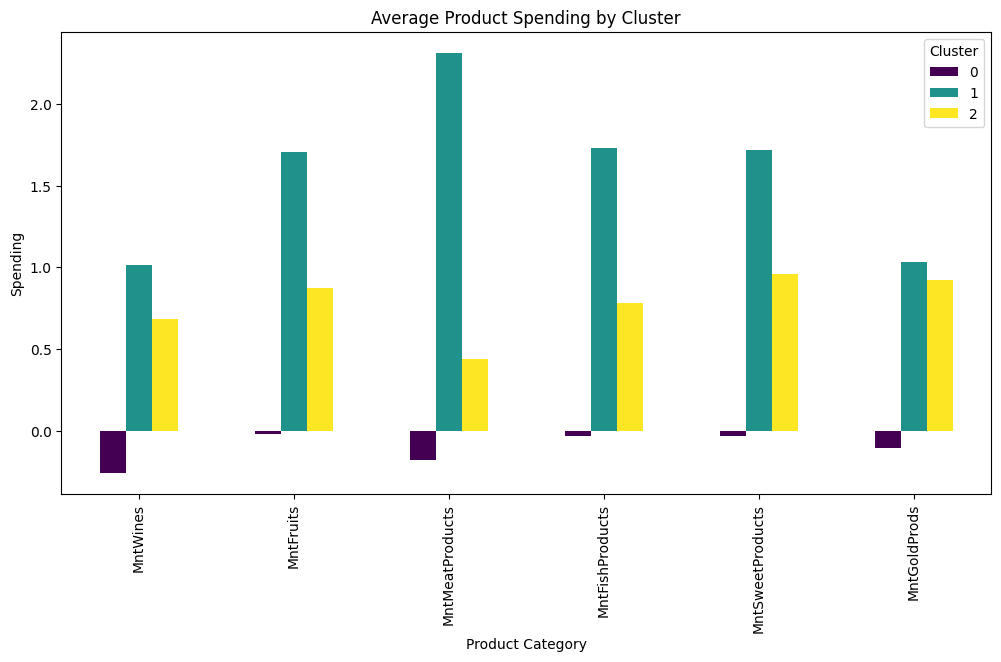

In [ ]:
import seaborn as sns
kmeans = KMeans(n_clusters=3, random_state=42)
final_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Summarize product spending by cluster
product_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
cluster_summary = final_df.groupby('Cluster')[product_features].mean()

# Visualize
cluster_summary.T.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Average Product Spending by Cluster')
plt.ylabel('Spending')
plt.xlabel('Product Category')
plt.legend(title='Cluster')
plt.show()


## Prédiction du 'churn' client

In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Create a churn proxy variable (e.g., low engagement)
final_df['Churn'] = (final_df['Recency'] > 90).astype(int)  # Example: recent engagement threshold
y = final_df['Churn']
X = final_df.drop(columns=['Churn', 'ID'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Evaluate model
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot confusion matrix
disp.plot(cmap="Blues", ax=ax[0])
ax[0].set_title("Confusion Matrix (Logistic Regression)", fontsize=14)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_title('ROC Curve', fontsize=14)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0